In [1]:
from IPython.display import clear_output

In [2]:
from fastai.tabular import *
from fastai.callback import *

In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# plot options
plt.rcParams.update({'font.size': 11})

#print option
pd.set_option("display.max_columns", 500)

Get the titanic dataset via the kaggle API (requires uploading your API key to Colab)

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c titanic

clear_output()

In [43]:
# training 
# titdf=pd.read_csv('/content/train.csv').set_index('PassengerId')

# testing
titdf=pd.read_csv('/content/test.csv').set_index('PassengerId')

Some Pandas built-in EDA

In [44]:
display(titdf.head())
display(titdf.describe())
display(titdf.info())

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


None

# Feature preprocessing

In [45]:
# in the test set Fare has a nan
titdf['Fare']=titdf['Fare'].fillna(titdf['Fare'].median())

Turn the Cabin data into something a bit more useful: make the letter a categorical variable, and the number a continuous variable. Also make a new column indicating missing values

In [46]:
titdf['Cabin_letter']=titdf['Cabin'].str[0].fillna('NA')

In [47]:
cbnums=titdf['Cabin'].str[1:]
cbnums=cbnums[~cbnums.isna()]
cbnums=cbnums.str.extract('(\d+)')[0].str.strip().fillna(-1).astype('int32')
titdf['Cabin_num']=-1
titdf.loc[cbnums.index,'Cabin_num']=cbnums
titdf['Cabin_num_na']=titdf['Cabin_num']==-1

Borrowed this code (nearly) verbatim from https://www.kaggle.com/nguyncaoduy/titanic-fastai-tabular-learner

Makes a categorical feature 'Title'

In [48]:
title_dict = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}
titdf['Title'] = titdf['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
titdf['Title'] = titdf['Title'].map(title_dict)

taken verbatim from https://www.kaggle.com/startupsci/titanic-data-science-solutions to create a continuous variable FamilySize and a Boolean Is_Alone

In [49]:
titdf['FamilySize'] = titdf['SibSp'] + titdf['Parch'] + 1
titdf['Is_Alone']=titdf['FamilySize']==1

## set up categorical and continuous variables


In [50]:
# drop the GAME_DATE (datetime type) column
titdf=titdf.drop(['Name','Ticket','Cabin'],axis=1)

titdf['Embarked']=titdf['Embarked'].fillna('S')

In [51]:
dep_var = 'Survived'
catnames=['Pclass','Sex','Embarked','Cabin_letter','Cabin_num_na','Is_Alone','Title']

allcols=titdf.columns.to_list()
contnames=[x for x in allcols if x not in catnames and x!=dep_var]

procs = [FillMissing, Categorify, Normalize]

In [52]:
print(titdf.shape)
print('Categorical columns: '+str(len(catnames)))
print('Continuous columns: '+str(len(contnames)))
# games_records.head()

(418, 13)
Categorical columns: 7
Continuous columns: 6


In [15]:
print(contnames)
print(catnames)
print(dep_var)

['Age', 'SibSp', 'Parch', 'Fare', 'Cabin_num', 'FamilySize']
['Pclass', 'Sex', 'Embarked', 'Cabin_letter', 'Cabin_num_na', 'Is_Alone', 'Title']
Survived


In [16]:
data = (TabularList.from_df(titdf.copy(), procs=procs, cont_names=contnames, cat_names=catnames)
                          #  .split_by_idx(valids)
                          # .split_by_idx(list(range(12500,13006)))
                          .split_by_rand_pct(0.1)
                           .label_from_df(cols=dep_var)
                           .databunch())

My custom wrapper function for the fastai learning rate finder tool

In [17]:
 def lr_find_BPI(learner,use_min_grad=False,show_plot=False,wd=None):
  learner.lr_find(wd=wd);

  skip_start=10
  skip_end=5

  lrs = learner.recorder.lrs[skip_start:-skip_end]
  losses = learner.recorder.losses[skip_start:-skip_end]
  losses = [x.item() for x in losses]

  spl = scipy.interpolate.UnivariateSpline(np.log10(lrs), losses,k=4)
  smth_losses = spl(np.log10(lrs))

  mg = (np.gradient(np.array(smth_losses))).argmin()
  opt_lr_mg=lrs[mg]

  ml = np.argmin(smth_losses)
  opt_lr_ml=lrs[ml]/10

  if show_plot:
    fig, ax = plt.subplots(1,1)
    ax.plot(lrs, losses,linewidth=2.5)
    ax.plot(lrs,smth_losses,linewidth=2.5)
    opt_lr_mg_dot=ax.plot(opt_lr_mg,smth_losses[mg],markersize=12,marker='o',color='red',
                          fillstyle='none',markeredgewidth=3,label='min grad')
    opt_lr_ml_dot=ax.plot(opt_lr_ml,smth_losses[np.abs(np.array(lrs)-opt_lr_ml).argmin()],
                          markersize=12,marker='o',color='black', fillstyle='none',markeredgewidth=3,label='min loss / 10')
    # opt_lr_ml_line=plt.axvline(x=opt_lr_ml,color='black',label='min loss /10')
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
    plt.legend()

  print('Min numerical gradient: {:.1e}'.format(opt_lr_mg))
  print('Min loss divided by 10: {:.1e}'.format(opt_lr_ml))

  if use_min_grad:
    print('Returned LR: {:.1e}'.format(opt_lr_mg))
    return opt_lr_mg
  else:
    print('Returned LR: {:.1e}'.format(opt_lr_ml))
    return opt_lr_ml

# Train

In [18]:
learn = tabular_learner(data, layers=[500,50,10], ps=[0.5**(ii) for ii in [1,2,3]],wd=0.3,emb_drop=0.1,
                        callback_fns=ShowGraph,metrics=accuracy)     

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.8e-02
Min loss divided by 10: 2.8e-01
Returned LR: 5.8e-02


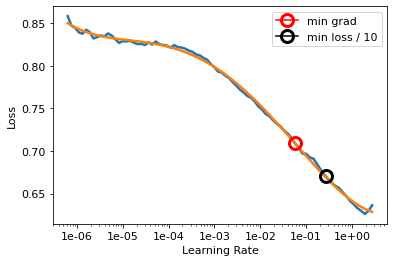

In [19]:
opt_lr=lr_find_BPI(learn,use_min_grad=True,show_plot=True,wd=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,0.638405,0.576855,0.707865,00:00
1,0.552921,0.393931,0.853933,00:00
2,0.506990,0.392201,0.887640,00:00
3,0.481280,0.393284,0.842697,00:00
4,0.459836,0.374438,0.865169,00:00


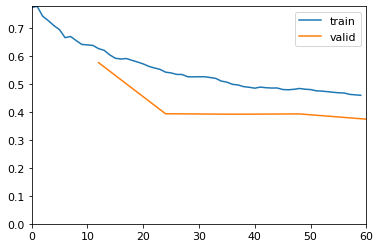

In [20]:
learn.fit_one_cycle(5,opt_lr,wd=0.3)

In [54]:
# for testing and submission
survived_pred={}
for passid,passrow in titdf.iterrows():
  survived_pred[passid]=int(learn.predict(passrow)[1].numpy())

In [55]:
df_submission=pd.DataFrame(survived_pred.items(), columns=['PassengerID', 'Survived'])
df_submission

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [56]:
df_submission.to_csv('/content/models/submission.csv', index=False)

In [57]:
!kaggle competitions submit Titanic -f {'/content/models/submission.csv'} -m '200709_1'

100% 2.77k/2.77k [00:00<00:00, 13.2kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster

78%